### DEseq2 analysis - python part
## Input with spike-in normalized value
<p style="text-align: right;"> Written by Soomin Son
<p style="text-align: right;"> Last revised: 18. 10. 2021.</p>

### Purpose

- Find differentially expressed miRNAs after serum starvation (0.1 % FBS, 72 hr)
- FBS rep1,2,3 & SS rep1,2,3
- Preparing for input dataframe for DEseq2 and Making plots with the results from DEseq2

---
### Settings

In [1]:
import sys
sys.path.append('/casa/soomin/miniconda3/lib/python3.7/site-packages/')
sys.path.append('/casa/soomin/miniconda3/envs/py37/lib/python3.7/site-packages/')
sys.path.append('/casa/soomin/miniconda3/envs/py37/lib/python3.8/site-packages')

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib_venn import venn2

from scipy import stats
from scipy.stats import mannwhitneyu
from statannot import add_stat_annotation

import numpy as np
import pybedtools
import seaborn as sns
sns.set(style="ticks", palette="muted")

In [3]:
from matplotlib import font_manager

font_dirs = ['/casa/soomin/font/Helvetica/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [71]:
samples =  'FBS_1 SS_1 FBS_2 SS_2 FBS_3 SS_3'.split()

---
### Raw count of miRNAs

In [72]:
Count_FBS1_df = pd.read_csv('../211005_serum_starvation_AQ_seq_raw/scratch_count/FBSrep1.readcount', sep='\t', header=None)
Count_FBS1_df.columns = 'chr start end mature pri strand FBS1_count'.split()

Count_SS1_df = pd.read_csv('../211005_serum_starvation_AQ_seq_raw/scratch_count/SSrep1.readcount', sep='\t', header=None)
Count_SS1_df.columns = 'chr start end mature pri strand SS1_count'.split()

Count_FBS2_df = pd.read_csv('../211005_serum_starvation_AQ_seq_raw/scratch_count/FBSrep2.readcount', sep='\t', header=None)
Count_FBS2_df.columns = 'chr start end mature pri strand FBS2_count'.split()

Count_SS2_df = pd.read_csv('../211005_serum_starvation_AQ_seq_raw/scratch_count/SSrep2.readcount', sep='\t', header=None)
Count_SS2_df.columns = 'chr start end mature pri strand SS2_count'.split()

Count_FBS3_df = pd.read_csv('../211005_serum_starvation_AQ_seq_raw/scratch_count/FBSrep3.readcount', sep='\t', header=None)
Count_FBS3_df.columns = 'chr start end mature pri strand FBS3_count'.split()

Count_SS3_df = pd.read_csv('../211005_serum_starvation_AQ_seq_raw/scratch_count/SSrep3.readcount', sep='\t', header=None)
Count_SS3_df.columns = 'chr start end mature pri strand SS3_count'.split()

In [73]:
Count_raw_df = pd.DataFrame(index=Count_FBS1_df["mature"].drop_duplicates())
Count_raw_df = Count_raw_df.sort_index()

Count_raw_df = Count_raw_df.join(pd.DataFrame(Count_FBS1_df.groupby("mature").apply(lambda x: sum(x['FBS1_count']) / len(x['pri']))))
Count_raw_df = Count_raw_df.rename(columns={0:'FBS_1'})
Count_raw_df = Count_raw_df.join(pd.DataFrame(Count_SS1_df.groupby("mature").apply(lambda x: sum(x['SS1_count']) / len(x['pri']))))
Count_raw_df = Count_raw_df.rename(columns={0:'SS_1'})

Count_raw_df = Count_raw_df.join(pd.DataFrame(Count_FBS2_df.groupby("mature").apply(lambda x: sum(x['FBS2_count']) / len(x['pri']))))
Count_raw_df = Count_raw_df.rename(columns={0:'FBS_2'})
Count_raw_df = Count_raw_df.join(pd.DataFrame(Count_SS2_df.groupby("mature").apply(lambda x: sum(x['SS2_count']) / len(x['pri']))))
Count_raw_df = Count_raw_df.rename(columns={0:'SS_2'})

Count_raw_df = Count_raw_df.join(pd.DataFrame(Count_FBS3_df.groupby("mature").apply(lambda x: sum(x['FBS3_count']) / len(x['pri']))))
Count_raw_df = Count_raw_df.rename(columns={0:'FBS_3'})
Count_raw_df = Count_raw_df.join(pd.DataFrame(Count_SS3_df.groupby("mature").apply(lambda x: sum(x['SS3_count']) / len(x['pri']))))
Count_raw_df = Count_raw_df.rename(columns={0:'SS_3'})

In [74]:
Count_raw_df.head()

,FBS_1,SS_1,FBS_2,SS_2,FBS_3,SS_3
mature,,,,,,
hsa-let-7a-2-3p,276.000000,334.000000,288.0,374.000000,252.000000,457.000000
hsa-let-7a-3p,1186.000000,1040.500000,1286.0,1318.500000,1125.500000,1450.000000
hsa-let-7a-5p,57571.666667,67682.333333,62040.0,104523.333333,58446.666667,105701.333333
hsa-let-7b-3p,499.000000,810.000000,599.0,1362.000000,374.000000,667.000000
hsa-let-7b-5p,16386.000000,23339.000000,17629.0,34599.000000,14748.000000,30171.000000


--- 

### Load DROSHA-dependency information

In [4]:
drosha_dependency = pd.read_table("../200521_HCT116_analysis/200326_curated_hg38_mature_miRNA_classification.txt")[["mature miRNA", "curated DROSHA dependency (HCT116)"]]
drosha_dependency[drosha_dependency["mature miRNA"] == "hsa-miR-941"]

,mature miRNA,curated DROSHA dependency (HCT116)
1705,hsa-miR-941,DROSHA-dependent
1706,hsa-miR-941,DROSHA-dependent
1707,hsa-miR-941,DROSHA-dependent
1708,hsa-miR-941,DROSHA-dependent
1709,hsa-miR-941,DROSHA-dependent


In [5]:
print(drosha_dependency.shape)

# Drop duplicates (because of multiple pri-miRNAs)

drosha_dependency = drosha_dependency.drop_duplicates().set_index("mature miRNA")
print(drosha_dependency.shape)

(2813, 2)
(2589, 1)


In [6]:
curated_dependency=drosha_dependency[~drosha_dependency["curated DROSHA dependency (HCT116)"].isna()]
curated_dependency.head()

del drosha_dependency

In [7]:
curated_dependency.head()

,curated DROSHA dependency (HCT116)
mature miRNA,
hsa-miR-200b-5p,DROSHA-dependent
hsa-miR-200b-3p,DROSHA-dependent
hsa-miR-200a-5p,DROSHA-dependent
hsa-miR-200a-3p,DROSHA-dependent
hsa-miR-429,DROSHA-dependent


---
### RPM normalization

In [79]:
RPM_df = Count_raw_df.div(Count_raw_df.sum(axis=0), axis=1) * 1000000
RPM_df.sum()

FBS_1    1000000.0
SS_1     1000000.0
FBS_2    1000000.0
SS_2     1000000.0
FBS_3    1000000.0
SS_3     1000000.0
dtype: float64

In [80]:
RPM_df.tail()

,FBS_1,SS_1,FBS_2,SS_2,FBS_3,SS_3
mature,,,,,,
hsa-miR-98-5p,2181.632503,1653.948029,2253.442023,2058.744849,2382.597249,2112.528431
hsa-miR-99a-3p,0.000000,0.566809,0.000000,0.000000,0.000000,0.000000
hsa-miR-99a-5p,9.178575,27.773630,16.604873,22.301348,10.912659,17.039382
hsa-miR-99b-3p,131.368352,96.924302,103.914369,102.008020,99.772884,91.586680
hsa-miR-99b-5p,2431.748667,1867.068131,2274.867666,1858.445701,1700.296226,1555.908606


#### Reproducibility with RPM

RPM cutoff = 10 

In [81]:
# rearrange columns
# add pseudocount
# apply RPM cutoff 10

pseudocount = 1 
rep_RPM = RPM_df[(RPM_df.iloc[:, 0:6] >=10).sum(axis=1) >= 3]
rep_RPM = rep_RPM[['FBS_1', 'FBS_2', 'FBS_3', 'SS_1', 'SS_2', 'SS_3']] + pseudocount
rep_RPM = rep_RPM.join(curated_dependency, how='left')

rep_RPM.head()

,FBS_1,FBS_2,FBS_3,SS_1,SS_2,SS_3,curated DROSHA dependency (HCT116)
mature,,,,,,,
hsa-let-7a-2-3p,159.330416,155.264631,131.951910,190.314134,155.457487,163.229120,DROSHA-dependent
hsa-let-7a-3p,681.361859,689.834429,585.866566,590.764539,545.524590,515.731343,DROSHA-dependent
hsa-let-7a-5p,33027.615639,33232.172593,30372.835814,38363.940984,43167.875449,37523.613319,DROSHA-dependent
hsa-let-7b-3p,287.256802,321.849007,195.349263,460.115114,563.489566,237.776418,DROSHA-dependent
hsa-let-7b-5p,9401.007941,9443.816596,7664.804630,13229.750185,14289.969516,10711.316803,DROSHA-dependent


In [82]:
rep_RPM[rep_RPM['curated DROSHA dependency (HCT116)'] !='DROSHA-dependent']

,FBS_1,FBS_2,FBS_3,SS_1,SS_2,SS_3,curated DROSHA dependency (HCT116)
mature,,,,,,,
hsa-miR-1226-3p,47.466535,36.887952,30.100424,14.036602,15.867566,16.264447,Mirtron
hsa-miR-1226-5p,18.783489,12.248463,11.393009,3.267235,2.651952,2.774936,Mirtron
hsa-miR-1229-3p,25.093759,15.462309,11.912659,11.202558,8.020795,6.324807,Mirtron
hsa-miR-1246,23.946437,27.782054,25.943221,14.036602,6.368843,7.389768,NaN
hsa-miR-1254,60.087075,45.993851,39.454132,31.040865,33.213059,26.204086,NaN
hsa-miR-1260b,213.254543,297.745158,275.895081,315.578875,234.751170,256.590736,NaN
hsa-miR-1268b,14.767862,21.354361,17.109164,8.935323,11.324698,7.389768,NaN
hsa-miR-1275,34.845995,36.887952,30.620075,21.971925,17.519517,14.134524,NaN
hsa-miR-1292-5p,57.792432,48.672056,43.091685,32.174483,32.387083,18.394370,Mirtron


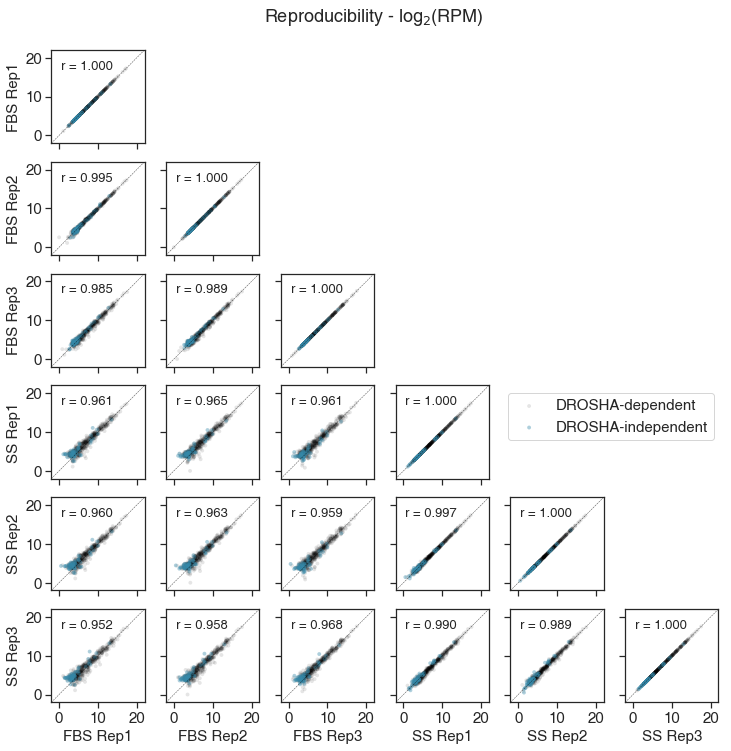

In [176]:
fig , ax = plt.subplots(6,6, figsize=(12,12), sharex = True, sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for row in range(0,5):
    for col in range(row+1,6):
        ax[row][col].remove()

for row in range(0,6):
    for col in range(0, row+1):
        ax[row][col].scatter(np.log2(rep_RPM[rep_RPM['curated DROSHA dependency (HCT116)'] =='DROSHA-dependent'].iloc[:,row]), \
                             np.log2(rep_RPM[rep_RPM['curated DROSHA dependency (HCT116)'] =='DROSHA-dependent'].iloc[:,col]),\
                            c='black', s=15, alpha=0.1, edgecolors = 'none', label='DROSHA-dependent')
        
        ax[row][col].scatter(np.log2(rep_RPM[rep_RPM['curated DROSHA dependency (HCT116)'] !='DROSHA-dependent'].iloc[:,row]), \
                             np.log2(rep_RPM[rep_RPM['curated DROSHA dependency (HCT116)'] !='DROSHA-dependent'].iloc[:,col]),\
                            c='#3689a9', s=15, alpha=0.4, edgecolors = 'none', label='DROSHA-independent')

        
        r = stats.pearsonr(np.log2(rep_RPM.iloc[:,row]), np.log2(rep_RPM.iloc[:,col]))[0]
        ax[row][col].text(0.5,17, 'r = %.3f'%r, fontsize = 13)
        
        ax[row][col].set_xlim(-2,22)
        ax[row][col].set_ylim(-2,22)
        ax[row][col].set_xticks([0,10,20])
        ax[row][col].plot(ax[row][col].get_xlim(), ax[row][col].get_ylim(), linewidth=0.5, c='black', alpha=0.7, ls='--')
        ax[row][col].set_aspect('equal', adjustable='box')
        
        for label in (ax[row][col].get_xticklabels() + ax[row][col].get_yticklabels()) :
            label.set_fontsize(15)
            
ax[0][0].set_ylabel("FBS Rep1", fontsize=15)
ax[1][0].set_ylabel("FBS Rep2", fontsize=15)
ax[2][0].set_ylabel("FBS Rep3", fontsize=15)
ax[3][0].set_ylabel("SS Rep1", fontsize=15)
ax[4][0].set_ylabel("SS Rep2", fontsize=15)
ax[5][0].set_ylabel("SS Rep3", fontsize=15)

ax[5][0].set_xlabel("FBS Rep1", fontsize=15)
ax[5][1].set_xlabel("FBS Rep2", fontsize=15)
ax[5][2].set_xlabel("FBS Rep3", fontsize=15)
ax[5][3].set_xlabel("SS Rep1", fontsize=15)
ax[5][4].set_xlabel("SS Rep2", fontsize=15)
ax[5][5].set_xlabel("SS Rep3", fontsize=15)

ax[3][3].legend(bbox_to_anchor=(3.5,1), loc='upper right', scatterpoints=1, fontsize=15)

fig.suptitle('Reproducibility - log$_2$(RPM)', fontsize=18, y=0.93)
fig.show()

#plt.savefig("Results/Figures/211111-reproducibility(RPM).pdf", bbox_inches='tight')

In [127]:
RPM_df.loc['hsa-miR-34a-5p']

FBS_1    1210.998216
SS_1     3332.835644
FBS_2    1165.554990
SS_2     3369.981538
FBS_3    2441.317748
SS_3     4873.263368
Name: hsa-miR-34a-5p, dtype: float64

In [132]:
tmp2 = pd.DataFrame(index=RPM_df.index)
tmp2['avg'] = (np.log2(RPM_df['SS_1']+1) + np.log2(RPM_df['SS_2']+1) + np.log2(RPM_df['SS_3']+1) - np.log2(RPM_df['FBS_1']+1) \
              - np.log2(RPM_df['FBS_2']+1)- np.log2(RPM_df['FBS_3']+1))/3
tmp2.head()

,avg
mature,
hsa-let-7a-2-3p,0.188346
hsa-let-7a-3p,-0.242799
hsa-let-7a-5p,0.299491
hsa-let-7b-3p,0.590403
hsa-let-7b-5p,0.524425


Not sure whether DROSHA-independent miRNAs do not change under serum starvation.

Use spike-in normalization

---
### Raw counts of Spike-Ins

In [86]:
spk_FBS1 = pd.read_csv('../211005_serum_starvation_AQ_seq_raw/scratch_spikeins/FBSrep1_SpikeIn_uniq.txt', sep='\t', header=None)
spk_FBS1.columns = 'FBS_1 Spike-In'.split()
spk_SS1 = pd.read_csv('../211005_serum_starvation_AQ_seq_raw/scratch_spikeins/SSrep1_SpikeIn_uniq.txt', sep='\t', header=None)
spk_SS1.columns = 'SS_1 Spike-In'.split()

spk_FBS2 = pd.read_csv('../211005_serum_starvation_AQ_seq_raw/scratch_spikeins/FBSrep2_SpikeIn_uniq.txt', sep='\t', header=None)
spk_FBS2.columns = 'FBS_2 Spike-In'.split()
spk_SS2 = pd.read_csv('../211005_serum_starvation_AQ_seq_raw/scratch_spikeins/SSrep2_SpikeIn_uniq.txt', sep='\t', header=None)
spk_SS2.columns = 'SS_2 Spike-In'.split()

spk_FBS3 = pd.read_csv('../211005_serum_starvation_AQ_seq_raw/scratch_spikeins/FBSrep3_SpikeIn_uniq.txt', sep='\t', header=None)
spk_FBS3.columns = 'FBS_3 Spike-In'.split()
spk_SS3 = pd.read_csv('../211005_serum_starvation_AQ_seq_raw/scratch_spikeins/SSrep3_SpikeIn_uniq.txt', sep='\t', header=None)
spk_SS3.columns = 'SS_3 Spike-In'.split()

In [87]:
spk_raw_df = pd.DataFrame(index=spk_FBS1["Spike-In"])

spk_raw_df = spk_raw_df.join(pd.DataFrame(spk_FBS1).set_index('Spike-In'))
spk_raw_df = spk_raw_df.join(pd.DataFrame(spk_SS1).set_index('Spike-In'))
spk_raw_df = spk_raw_df.join(pd.DataFrame(spk_FBS2).set_index('Spike-In'))
spk_raw_df = spk_raw_df.join(pd.DataFrame(spk_SS2).set_index('Spike-In'))
spk_raw_df = spk_raw_df.join(pd.DataFrame(spk_FBS3).set_index('Spike-In'))
spk_raw_df = spk_raw_df.join(pd.DataFrame(spk_SS3).set_index('Spike-In'))

In [88]:
#spk_raw_df.to_csv("Results/Count_SpikeIns.txt", sep='\t')

In [89]:
SpikeIns_df = pd.read_csv("Results/Count_SpikeIns.txt", sep="\t")
SpikeIns_df = SpikeIns_df.set_index("Spike-In")
print(SpikeIns_df.shape)
SpikeIns_df.head()

(30, 6)


,FBS_1,SS_1,FBS_2,SS_2,FBS_3,SS_3
Spike-In,,,,,,
spk_1,1164,393,1107,506,874,543
spk_10,1624,833,1442,986,1638,519
spk_11,2616,1013,2490,1269,1598,969
spk_12,3526,1389,3494,1712,3274,1592
spk_13,2211,941,2355,1395,1379,782


In [90]:
all_spkn = list(SpikeIns_df.index)
np.random.seed(7)

norm_spkn = list(np.random.choice(all_spkn, 20, replace=False))
other_spkn = [spkn for spkn in all_spkn if spkn not in norm_spkn]

print(len(norm_spkn), len(other_spkn))
print("norm spike-in: " + ", ".join(norm_spkn))
print("other spike-in: " + ", ".join(other_spkn))

20 10
norm spike-in: spk_11, spk_25, spk_10, spk_18, spk_2, spk_14, spk_26, spk_4, spk_7, spk_9, spk_20, spk_21, spk_24, spk_1, spk_8, spk_15, spk_6, spk_28, spk_19, spk_29
other spike-in: spk_12, spk_13, spk_16, spk_17, spk_22, spk_23, spk_27, spk_3, spk_30, spk_5


In [91]:
norm_spkn_gmean = \
pd.DataFrame(stats.gmean(SpikeIns_df.loc[norm_spkn].iloc[:,:]), index=samples, columns=["g_mean"]).T

norm_spkn_gmean.head()

,FBS_1,SS_1,FBS_2,SS_2,FBS_3,SS_3
g_mean,2183.294573,848.335893,2069.28698,1113.522935,1555.031026,835.983923


In [92]:
other_spkn_df = SpikeIns_df.loc[other_spkn].iloc[:,:]
other_spkn_df.columns = samples
other_spkn_df.head()

,FBS_1,SS_1,FBS_2,SS_2,FBS_3,SS_3
Spike-In,,,,,,
spk_12,3526,1389,3494,1712,3274,1592
spk_13,2211,941,2355,1395,1379,782
spk_16,2927,1066,2568,1224,1724,950
spk_17,1467,489,1393,662,1044,621
spk_22,1424,703,1191,702,951,527


--- 
### Spike-in normalized count of miRNAs

In [93]:
count_norm_df = pd.DataFrame(index=Count_raw_df.index)
other_spkn_norm_df = pd.DataFrame(index=other_spkn_df.index)

for s in samples:
    count_norm_df[s] = Count_raw_df[s]/norm_spkn_gmean[s][0]
    other_spkn_norm_df[s] = other_spkn_df[s]/norm_spkn_gmean[s][0]
    
count_norm_df.head()

,FBS_1,SS_1,FBS_2,SS_2,FBS_3,SS_3
mature,,,,,,
hsa-let-7a-2-3p,0.126414,0.393712,0.139178,0.335871,0.162055,0.546661
hsa-let-7a-3p,0.543216,1.226519,0.621470,1.184080,0.723780,1.734483
hsa-let-7a-5p,26.369170,79.782471,29.981342,93.867248,37.585531,126.439433
hsa-let-7b-3p,0.228554,0.954810,0.289472,1.223145,0.240510,0.797862
hsa-let-7b-5p,7.505171,27.511508,8.519360,31.071655,9.484055,36.090407


In [94]:
other_spkn_norm_df.head()

,FBS_1,SS_1,FBS_2,SS_2,FBS_3,SS_3
Spike-In,,,,,,
spk_12,1.614991,1.637323,1.688504,1.537463,2.105424,1.904343
spk_13,1.012690,1.109230,1.138073,1.252781,0.886799,0.935425
spk_16,1.340634,1.256578,1.241007,1.099214,1.108660,1.136385
spk_17,0.671920,0.576423,0.673179,0.594510,0.671369,0.742837
spk_22,0.652225,0.828681,0.575561,0.630432,0.611563,0.630395


#### Scaling 

In [95]:
scale_set1 = round(float(norm_spkn_gmean.iloc[:,0:2].max(axis=1)))
scale_set2 = round(float(norm_spkn_gmean.iloc[:,2:4].max(axis=1)))
scale_set3 = round(float(norm_spkn_gmean.iloc[:,4:6].max(axis=1)))

print(scale_set1, scale_set2, scale_set3)

2183 2069 1555


In [96]:
scaled_count_norm_df = pd.DataFrame(index=count_norm_df.index, columns=count_norm_df.columns)
scaled_other_spkn_norm_df = pd.DataFrame(index=other_spkn_norm_df.index, columns=other_spkn_norm_df.columns)

scaled_count_norm_df.iloc[:, 0:2] = count_norm_df.iloc[:,0:2] * scale_set1
scaled_other_spkn_norm_df.iloc[:,0:2] = other_spkn_norm_df.iloc[:,0:2] * scale_set1

scaled_count_norm_df.iloc[:, 2:4] = count_norm_df.iloc[:,2:4] * scale_set2
scaled_other_spkn_norm_df.iloc[:,2:4] = other_spkn_norm_df.iloc[:,2:4] * scale_set2

scaled_count_norm_df.iloc[:, 4:6] = count_norm_df.iloc[:,4:6] * scale_set3
scaled_other_spkn_norm_df.iloc[:,4:6] = other_spkn_norm_df.iloc[:,4:6] * scale_set3


scaled_count_norm_df.head()

,FBS_1,SS_1,FBS_2,SS_2,FBS_3,SS_3
mature,,,,,,
hsa-let-7a-2-3p,275.963,859.473,287.96,694.917,251.995,850.058
hsa-let-7a-3p,1185.84,2677.49,1285.82,2449.86,1125.48,2697.12
hsa-let-7a-5p,57563.9,174165,62031.4,194211,58445.5,196613
hsa-let-7b-3p,498.933,2084.35,598.917,2530.69,373.993,1240.68
hsa-let-7b-5p,16383.8,60057.6,17626.6,64287.3,14747.7,56120.6


In [97]:
scaled_count_norm_df = scaled_count_norm_df.applymap(round)
scaled_other_spkn_norm_df = scaled_other_spkn_norm_df.applymap(round)

scaled_count_norm_df.head()

,FBS_1,SS_1,FBS_2,SS_2,FBS_3,SS_3
mature,,,,,,
hsa-let-7a-2-3p,276,859,288,695,252,850
hsa-let-7a-3p,1186,2677,1286,2450,1125,2697
hsa-let-7a-5p,57564,174165,62031,194211,58446,196613
hsa-let-7b-3p,499,2084,599,2531,374,1241
hsa-let-7b-5p,16384,60058,17627,64287,14748,56121


In [98]:
norm_count_with_spikeIn = pd.concat([scaled_count_norm_df, scaled_other_spkn_norm_df])
norm_count_with_spikeIn.loc['hsa-miR-205-5p']

FBS_1     15
SS_1     533
FBS_2     13
SS_2     478
FBS_3     28
SS_3     528
Name: hsa-miR-205-5p, dtype: int64

In [609]:
norm_count_with_spikeIn.head()

,FBS_1,SS_1,FBS_2,SS_2,FBS_3,SS_3
hsa-let-7a-2-3p,276,859,288,695,252,850
hsa-let-7a-3p,1186,2677,1286,2450,1125,2697
hsa-let-7a-5p,57564,174165,62031,194211,58446,196613
hsa-let-7b-3p,499,2084,599,2531,374,1241
hsa-let-7b-5p,16384,60058,17627,64287,14748,56121


---

### Make CSV for DEseq2 analysis

In [275]:
### norm counts including spike-ins
#norm_count_with_spikeIn.to_csv("Results/norm_count_w_spikeIn.csv")

--- 

### Load miRNA information

In [8]:
pri_info = pd.read_csv("../../work/190905_sRNA_HCT116_rescue_set_3/190712_pri-info_BK.csv", sep = ',')

pri_info.columns = ["pri-miRNA", "stem length", "loop", "simple loop", "UG", "CNNC", "UGU"]

pri_info["UG"] = np.where(pri_info["UG"] == "-", "NoUG", "UG")
pri_info["UGU"] = np.where(pri_info["UGU"] == "-", "NoUGU", "UGU")
pri_info["CNNC"] = np.where(pri_info["CNNC"] == "-", "NoCNNC", "CNNC")

print(pri_info.shape)
pri_info.head()

(401, 7)


,pri-miRNA,stem length,loop,simple loop,UG,CNNC,UGU
0,hsa-let-7a-1,36,27,4,NoUG,NoCNNC,NoUGU
1,hsa-let-7a-2,36,21,21,UG,CNNC,NoUGU
2,hsa-let-7a-3,35,24,3,UG,CNNC,NoUGU
3,hsa-let-7b,34,30,7,NoUG,NoCNNC,NoUGU
4,hsa-let-7c,37,21,21,UG,NoCNNC,NoUGU


In [9]:
mature_info = pd.read_table("../200521_HCT116_analysis/200326_curated_hg38_mature_miRNA_classification.txt")
mature_info.head()

,mature miRNA,Chr,mature Start,mature End,strand,pri miRNA,pri Start,pri End,DROSHA dependency,Clustered,Locus,Exon_Intron,HostGene,Direction,curated DROSHA dependency (HCT116)
0,hsa-miR-6859-5p,chr1,17409,17431,-,hsa-mir-6859-1,17369,17436,DROSHA-dependent,independent,intergenic,intergenic,0,0,NaN
1,hsa-miR-6859-3p,chr1,17369,17391,-,hsa-mir-6859-1,17369,17436,DROSHA-dependent,independent,intergenic,intergenic,0,0,NaN
2,hsa-miR-1302,chr1,30438,30458,+,hsa-mir-1302-2,30366,30503,DROSHA-dependent,independent,intergenic,intergenic,0,0,NaN
3,hsa-miR-6859-5p,chr1,187931,187953,-,hsa-mir-6859-2,187891,187958,DROSHA-dependent,independent,intergenic,intergenic,0,0,NaN
4,hsa-miR-6859-3p,chr1,187891,187913,-,hsa-mir-6859-2,187891,187958,DROSHA-dependent,independent,intergenic,intergenic,0,0,NaN


In [10]:
mature_info = mature_info[["mature miRNA","Chr","pri Start", "pri End", "strand", "pri miRNA","Clustered", "Locus", "Exon_Intron", "HostGene", "Direction", 'curated DROSHA dependency (HCT116)']]
print(mature_info.shape)
mature_info[mature_info["mature miRNA"] == 'hsa-miR-941']

(2813, 12)


,mature miRNA,Chr,pri Start,pri End,strand,pri miRNA,Clustered,Locus,Exon_Intron,HostGene,Direction,curated DROSHA dependency (HCT116)
1705,hsa-miR-941,chr20,63919449,63919520,+,hsa-mir-941-1,clustered,intragenic,exonic,DNAJC5,++,DROSHA-dependent
1706,hsa-miR-941,chr20,63919505,63919576,+,hsa-mir-941-2,clustered,intragenic,exonic,DNAJC5,++,DROSHA-dependent
1707,hsa-miR-941,chr20,63919561,63919632,+,hsa-mir-941-3,clustered,intragenic,exonic,DNAJC5,++,DROSHA-dependent
1708,hsa-miR-941,chr20,63919756,63919827,+,hsa-mir-941-4,clustered,intragenic,exonic,DNAJC5,++,DROSHA-dependent
1709,hsa-miR-941,chr20,63919868,63919939,+,hsa-mir-941-5,clustered,intragenic,exonic,DNAJC5,++,DROSHA-dependent


In [11]:
unique_mature_info = mature_info.drop_duplicates("mature miRNA", keep = False)
unique_mature_info[unique_mature_info["mature miRNA"] == 'hsa-miR-941']

,mature miRNA,Chr,pri Start,pri End,strand,pri miRNA,Clustered,Locus,Exon_Intron,HostGene,Direction,curated DROSHA dependency (HCT116)


In [12]:
all_info = \
unique_mature_info.set_index("pri miRNA").join(pri_info.set_index("pri-miRNA")).reset_index().rename(columns={'index':'pri-miRNA'}).set_index("mature miRNA")
print(all_info.shape)
all_info.head()

(2421, 17)


,pri-miRNA,Chr,pri Start,pri End,strand,Clustered,Locus,Exon_Intron,HostGene,Direction,curated DROSHA dependency (HCT116),stem length,loop,simple loop,UG,CNNC,UGU
mature miRNA,,,,,,,,,,,,,,,,,
hsa-let-7a-2-3p,hsa-let-7a-2,chr11,122146522,122146593,-,clustered,intergenic,intergenic,0,0,DROSHA-dependent,36.0,21.0,21.0,UG,CNNC,NoUGU
hsa-let-7b-5p,hsa-let-7b,chr22,46113686,46113768,+,clustered,intergenic,intergenic,0,0,DROSHA-dependent,34.0,30.0,7.0,NoUG,NoCNNC,NoUGU
hsa-let-7b-3p,hsa-let-7b,chr22,46113686,46113768,+,clustered,intergenic,intergenic,0,0,DROSHA-dependent,34.0,30.0,7.0,NoUG,NoCNNC,NoUGU
hsa-let-7c-5p,hsa-let-7c,chr21,16539828,16539911,+,clustered,intergenic,intergenic,0,0,DROSHA-dependent,37.0,21.0,21.0,UG,NoCNNC,NoUGU
hsa-let-7c-3p,hsa-let-7c,chr21,16539828,16539911,+,clustered,intergenic,intergenic,0,0,DROSHA-dependent,37.0,21.0,21.0,UG,NoCNNC,NoUGU


In [13]:
all_info = all_info[['pri-miRNA', 'Chr', 'pri Start', 'pri End', 'strand', 'curated DROSHA dependency (HCT116)']]

In [14]:
w_spikeIn = pd.read_csv("Results/DE_norm_w_spikeIn_shrink.csv")
w_spikeIn.rename(columns={'Unnamed: 0': 'mature'}, inplace=True)
w_spikeIn.set_index("mature", inplace=True)
w_spikeIn.head()

,baseMean,log2FoldChange,lfcSE,pvalue,padj
mature,,,,,
hsa-let-7a-2-3p,470.730086,0.606168,0.169966,1.638406e-04,1.201824e-03
hsa-let-7a-3p,1745.327777,0.196499,0.137321,1.377258e-01,3.026688e-01
hsa-let-7a-5p,107685.554916,0.731498,0.133835,1.652180e-08,3.049924e-07
hsa-let-7b-3p,1045.693691,0.987534,0.308271,2.427462e-04,1.710342e-03
hsa-let-7b-5p,32680.718539,0.948030,0.167534,3.481649e-09,8.032738e-08


In [15]:
w_spikeIn_info = w_spikeIn.join(curated_dependency, how='left')
w_spikeIn_info.head()

,baseMean,log2FoldChange,lfcSE,pvalue,padj,curated DROSHA dependency (HCT116)
mature,,,,,,
hsa-let-7a-2-3p,470.730086,0.606168,0.169966,1.638406e-04,1.201824e-03,DROSHA-dependent
hsa-let-7a-3p,1745.327777,0.196499,0.137321,1.377258e-01,3.026688e-01,DROSHA-dependent
hsa-let-7a-5p,107685.554916,0.731498,0.133835,1.652180e-08,3.049924e-07,DROSHA-dependent
hsa-let-7b-3p,1045.693691,0.987534,0.308271,2.427462e-04,1.710342e-03,DROSHA-dependent
hsa-let-7b-5p,32680.718539,0.948030,0.167534,3.481649e-09,8.032738e-08,DROSHA-dependent


In [16]:
w_spikeIn_info[(w_spikeIn_info.index.str.contains("spk")) & (w_spikeIn_info["padj"] < 0.05)]["log2FoldChange"]

mature
spk_12   -0.949252
spk_13   -0.647725
spk_16   -0.895395
spk_17   -0.956856
spk_22   -0.598539
spk_23   -0.931165
spk_3    -0.821524
spk_5    -0.880745
Name: log2FoldChange, dtype: float64

In [17]:
log2FC_cutoff = \
w_spikeIn_info[(w_spikeIn_info.index.str.contains("spk")) & (w_spikeIn_info["padj"] < 0.05)]["log2FoldChange"].abs().max()

print(log2FC_cutoff)

0.956855590981004


In [18]:
w_spikeIn_sig = \
w_spikeIn_info[(w_spikeIn_info["padj"] < 0.05) & (w_spikeIn_info["log2FoldChange"].abs() > log2FC_cutoff)]

print(w_spikeIn_sig.shape)
w_spikeIn_sig.head()

(106, 6)


,baseMean,log2FoldChange,lfcSE,pvalue,padj,curated DROSHA dependency (HCT116)
mature,,,,,,
hsa-let-7b-3p,1045.693691,0.987534,0.308271,2.427462e-04,1.710342e-03,DROSHA-dependent
hsa-let-7c-5p,1437.848483,1.069767,0.217055,1.533845e-07,2.283450e-06,DROSHA-dependent
hsa-miR-101-5p,53.095977,1.502835,0.433963,5.355477e-05,4.534959e-04,DROSHA-dependent
hsa-miR-107,10342.149793,1.069203,0.146441,5.551757e-14,3.416181e-12,DROSHA-dependent
hsa-miR-10a-5p,7767.264006,1.014247,0.140053,9.720389e-14,5.607449e-12,DROSHA-dependent


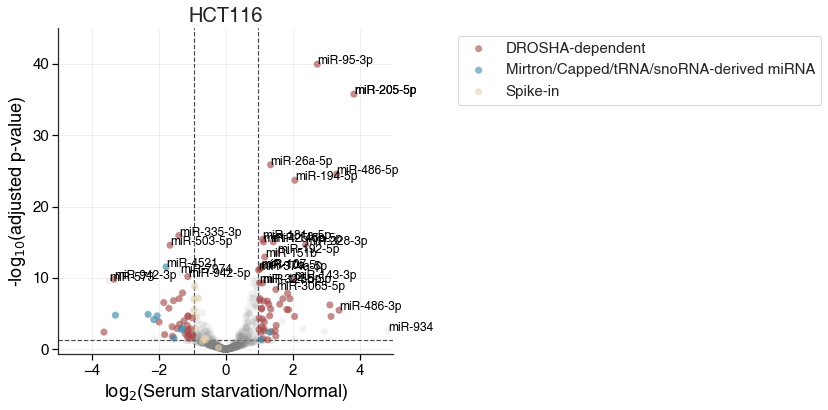

In [19]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.set_xlim(-5,5)
ax.set_ylim(-0.7,45)
ax.plot([log2FC_cutoff, log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)
ax.plot([-log2FC_cutoff, -log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)
ax.plot(ax.get_xlim(),[-np.log10(0.05), -np.log10(0.05)],c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)

allmiRNA = ax.scatter(w_spikeIn_info["log2FoldChange"], -np.log10(w_spikeIn_info["padj"]), s=50, c='grey', alpha=0.1, edgecolors='none', zorder=2)
spkn = ax.scatter(w_spikeIn_info[w_spikeIn_info.index.str.contains('spk')]["log2FoldChange"], \
                  -np.log10(w_spikeIn_info[w_spikeIn_info.index.str.contains('spk')]["padj"]),\
                  c='#e7d6b1', alpha=0.6, s=50, edgecolors='none', zorder=2)
DD = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["log2FoldChange"], \
                -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["padj"]),\
                c='#a84848', alpha=0.6, s=50, edgecolors='none', zorder=2)
MCSnoT = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['Capped miRNA', "Mirtron", 'SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["log2FoldChange"], \
                    -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['Capped miRNA', "Mirtron", 'SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["padj"]),\
                    c='#3689a9', alpha=0.6, s=50, edgecolors='none', zorder=2)


ax.set_xlabel("log$_2$(Serum starvation/Normal)", fontsize=18, color='black')
ax.set_ylabel("-log$_{10}$(adjusted p-value)", fontsize=18, color='black')
ax.legend((DD, MCSnoT, spkn), ("DROSHA-dependent", "Mirtron/Capped/tRNA/snoRNA-derived miRNA", "Spike-in"), \
          frameon=True, bbox_to_anchor=(2.3,1), loc='upper right', scatterpoints=1, fontsize=15)


for miRNA in w_spikeIn_sig.sort_values(by='padj').iloc[:25,:].index:
    name = ('-').join(miRNA.split('-')[1:])
    ax.text(w_spikeIn_sig.loc[miRNA, "log2FoldChange"], -np.log10(w_spikeIn_sig.loc[miRNA, "padj"]), name, fontsize=12, color='black')
for miRNA in w_spikeIn_sig.sort_values(by='log2FoldChange', ascending=False).iloc[:3,:].index:
    name = ('-').join(miRNA.split('-')[1:])
    ax.text(w_spikeIn_sig.loc[miRNA, "log2FoldChange"], -np.log10(w_spikeIn_sig.loc[miRNA, "padj"]), name, fontsize=12, color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, zorder=0)
ax.grid(axis='x', alpha=0.3, zorder=0)
#ax.spines['bottom'].set_position(('outward', 4))

ax.set_title("HCT116",fontsize=20)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

fig.show()
#plt.savefig("Results/Figures/211111-data-volcano-SS.pdf", bbox_inches='tight')

del allmiRNA, DD, MCSnoT

In [22]:
w_spikeIn_sig.sort_values(by='log2FoldChange', ascending=True)

,baseMean,log2FoldChange,lfcSE,pvalue,padj,curated DROSHA dependency (HCT116)
mature,,,,,,
hsa-miR-302c-3p,4.270880,-5.897960,2.722353,7.930746e-05,6.421122e-04,NaN
hsa-miR-1914-5p,5.667158,-3.640163,1.349819,6.489577e-04,3.864438e-03,DROSHA-dependent
hsa-miR-573,30.322837,-3.489381,0.537422,7.050058e-12,2.829219e-10,NaN
hsa-miR-942-3p,27.701625,-3.346935,0.506554,3.366225e-12,1.513234e-10,DROSHA-dependent
hsa-miR-4745-5p,14.626966,-3.299204,0.775149,1.356362e-06,1.647266e-05,Mirtron
...,...,...,...,...,...,...
hsa-miR-338-3p,18.738918,3.141919,0.738448,2.209988e-06,2.487585e-05,DROSHA-dependent
hsa-miR-486-5p,160.228055,3.309426,0.310348,1.193141e-27,2.753173e-25,DROSHA-dependent
hsa-miR-486-3p,27.877666,3.381873,0.724604,2.472874e-07,3.356562e-06,DROSHA-dependent


--- 

### Working with DEseq2 results

In [24]:
feature_all = w_spikeIn.join(all_info, how='left')
feature_all.head()

,baseMean,log2FoldChange,lfcSE,pvalue,padj,pri-miRNA,Chr,pri Start,pri End,strand,curated DROSHA dependency (HCT116)
mature,,,,,,,,,,,
hsa-let-7a-2-3p,470.730086,0.606168,0.169966,1.638406e-04,1.201824e-03,hsa-let-7a-2,chr11,122146522.0,122146593.0,-,DROSHA-dependent
hsa-let-7a-3p,1745.327777,0.196499,0.137321,1.377258e-01,3.026688e-01,NaN,NaN,NaN,NaN,NaN,NaN
hsa-let-7a-5p,107685.554916,0.731498,0.133835,1.652180e-08,3.049924e-07,NaN,NaN,NaN,NaN,NaN,NaN
hsa-let-7b-3p,1045.693691,0.987534,0.308271,2.427462e-04,1.710342e-03,hsa-let-7b,chr22,46113686.0,46113768.0,+,DROSHA-dependent
hsa-let-7b-5p,32680.718539,0.948030,0.167534,3.481649e-09,8.032738e-08,hsa-let-7b,chr22,46113686.0,46113768.0,+,DROSHA-dependent


In [25]:
feature_all["curated DROSHA dependency (HCT116)"].value_counts()

DROSHA-dependent        578
Mirtron                 459
SnoRNA-derived miRNA      9
Capped miRNA              5
tRNA-related miRNA        1
Name: curated DROSHA dependency (HCT116), dtype: int64

In [26]:
DD = feature_all[feature_all["curated DROSHA dependency (HCT116)"] == "DROSHA-dependent"]
print(DD.shape)
DD.head()

(578, 11)


,baseMean,log2FoldChange,lfcSE,pvalue,padj,pri-miRNA,Chr,pri Start,pri End,strand,curated DROSHA dependency (HCT116)
mature,,,,,,,,,,,
hsa-let-7a-2-3p,470.730086,0.606168,0.169966,1.638406e-04,1.201824e-03,hsa-let-7a-2,chr11,122146522.0,122146593.0,-,DROSHA-dependent
hsa-let-7b-3p,1045.693691,0.987534,0.308271,2.427462e-04,1.710342e-03,hsa-let-7b,chr22,46113686.0,46113768.0,+,DROSHA-dependent
hsa-let-7b-5p,32680.718539,0.948030,0.167534,3.481649e-09,8.032738e-08,hsa-let-7b,chr22,46113686.0,46113768.0,+,DROSHA-dependent
hsa-let-7c-3p,3.701289,0.233679,0.549898,2.263526e-01,4.220572e-01,hsa-let-7c,chr21,16539828.0,16539911.0,+,DROSHA-dependent
hsa-let-7c-5p,1437.848483,1.069767,0.217055,1.533845e-07,2.283450e-06,hsa-let-7c,chr21,16539828.0,16539911.0,+,DROSHA-dependent


In [27]:
DI = feature_all[feature_all["curated DROSHA dependency (HCT116)"].isin(["Mirtron","tRNA-related miRNA", "SnoRNA-derived miRNA", "Capped miRNA"])]
print(DI.shape)
DI.head()

(474, 11)


,baseMean,log2FoldChange,lfcSE,pvalue,padj,pri-miRNA,Chr,pri Start,pri End,strand,curated DROSHA dependency (HCT116)
mature,,,,,,,,,,,
hsa-miR-1178-3p,0.000000,NaN,NaN,NaN,NaN,hsa-mir-1178,chr12,119713634.0,119713724.0,-,Mirtron
hsa-miR-1178-5p,0.000000,NaN,NaN,NaN,NaN,hsa-mir-1178,chr12,119713634.0,119713724.0,-,Mirtron
hsa-miR-1224-3p,10.788782,-0.004681,0.400251,0.983325,0.987605,hsa-mir-1224,chr3,184241405.0,184241489.0,+,Mirtron
hsa-miR-1224-5p,23.945235,0.625444,0.442969,0.048787,0.140328,hsa-mir-1224,chr3,184241405.0,184241489.0,+,Mirtron
hsa-miR-1225-3p,2.100043,-0.140969,0.524973,0.328827,NaN,hsa-mir-1225,chr16,2090195.0,2090284.0,-,Mirtron


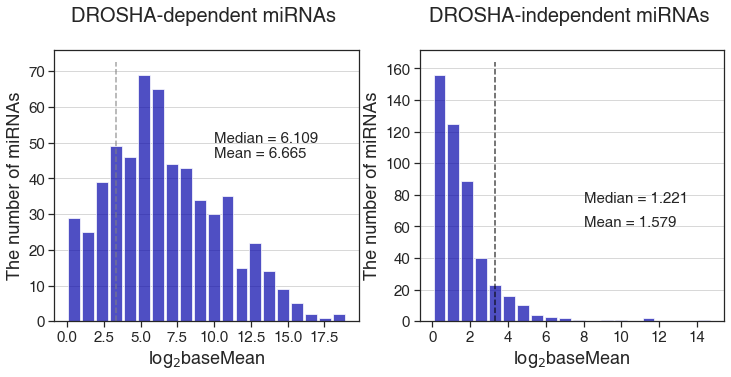

In [28]:
pseudocount = 1
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].hist(np.log2(DD['baseMean'] + pseudocount), bins=20, color='#0504aa',alpha=0.7, rwidth=0.85)
ax[0].grid(axis='y', alpha=0.75)
ax[0].set_xlabel("log$_2$baseMean", fontsize=18)
ax[0].set_ylabel('The number of miRNAs', fontsize=18)
ax[0].set_title('DROSHA-dependent miRNAs \n',fontsize=20)
ax[0].plot((np.log2(10), np.log2(10)), ax[0].get_ylim(), color='grey', alpha=0.7, ls='--')
ax[0].text(10,50,'Median = %.3f'%np.log2(DD['baseMean']+ pseudocount).median(), fontsize=15)
ax[0].text(10,46,'Mean = %.3f'%np.log2(DD['baseMean'] + pseudocount).mean(), fontsize=15)

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()) :
    label.set_fontsize(15)
    
ax[1].hist(np.log2(DI['baseMean']+ pseudocount), bins=20, color='#0504aa',alpha=0.7, rwidth=0.85)
ax[1].grid(axis='y', alpha=0.75)
ax[1].set_xlabel("log$_2$baseMean", fontsize=18)
ax[1].set_ylabel('The number of miRNAs', fontsize=18)
ax[1].set_title('DROSHA-independent miRNAs \n',fontsize=20)
ax[1].plot((np.log2(10), np.log2(10)), ax[1].get_ylim(), color='black', alpha=0.7, ls='--')
ax[1].text(8,75,'Median = %.3f'%np.log2(DI['baseMean']+ pseudocount).median(), fontsize=15)
ax[1].text(8,60,'Mean = %.3f'%np.log2(DI['baseMean']+ pseudocount).mean(), fontsize=15)

for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()) :
    label.set_fontsize(15)
    
fig.show()

In [29]:
DD_filtered = DD[DD['baseMean'] >= 2**4 ]
#DD_filtered = DD[DD['baseMean'] >= 2**6.1 ]
print(DD.shape)
print(DD_filtered.shape)
DD_filtered.head()

(578, 11)
(425, 11)


,baseMean,log2FoldChange,lfcSE,pvalue,padj,pri-miRNA,Chr,pri Start,pri End,strand,curated DROSHA dependency (HCT116)
mature,,,,,,,,,,,
hsa-let-7a-2-3p,470.730086,0.606168,0.169966,1.638406e-04,1.201824e-03,hsa-let-7a-2,chr11,122146522.0,122146593.0,-,DROSHA-dependent
hsa-let-7b-3p,1045.693691,0.987534,0.308271,2.427462e-04,1.710342e-03,hsa-let-7b,chr22,46113686.0,46113768.0,+,DROSHA-dependent
hsa-let-7b-5p,32680.718539,0.948030,0.167534,3.481649e-09,8.032738e-08,hsa-let-7b,chr22,46113686.0,46113768.0,+,DROSHA-dependent
hsa-let-7c-5p,1437.848483,1.069767,0.217055,1.533845e-07,2.283450e-06,hsa-let-7c,chr21,16539828.0,16539911.0,+,DROSHA-dependent
hsa-let-7d-3p,1326.729912,-0.229563,0.148533,1.054674e-01,2.520916e-01,hsa-let-7d,chr9,94178834.0,94178920.0,+,DROSHA-dependent


In [30]:
#DI_filtered = DI[DI['baseMean'] >= 2**6.1]
DI_filtered = DI[DI['baseMean'] >= 2**4]
print(DI.shape)
print(DI_filtered.shape)
DI_filtered.head()

(474, 11)
(31, 11)


,baseMean,log2FoldChange,lfcSE,pvalue,padj,pri-miRNA,Chr,pri Start,pri End,strand,curated DROSHA dependency (HCT116)
mature,,,,,,,,,,,
hsa-miR-1224-5p,23.945235,0.625444,0.442969,0.048787,0.140328,hsa-mir-1224,chr3,184241405.0,184241489.0,+,Mirtron
hsa-miR-1226-3p,70.520915,-0.791118,0.292314,0.001822,0.009667,hsa-mir-1226,chr3,47849555.0,47849629.0,+,Mirtron
hsa-miR-1226-5p,19.366821,-2.152939,0.552766,0.000007,0.000069,hsa-mir-1226,chr3,47849555.0,47849629.0,+,Mirtron
hsa-miR-1229-3p,33.146911,-0.435457,0.394341,0.129000,0.291831,hsa-mir-1229,chr5,179798278.0,179798346.0,-,Mirtron
hsa-miR-1292-5p,106.009403,-0.328428,0.274620,0.159883,0.333474,hsa-mir-1292,chr20,2652777.0,2652842.0,+,Mirtron


In [649]:
### middle check point
#DD_filtered.to_csv("Results/211018_SS_DD_filtered.csv")
#DI_filtered.to_csv("Results/211018_SS_DI_filtered.csv")
#DD.to_csv("Results/211018_SS_DD.csv")
#DI.to_csv("Results/211018_SS_DI.csv")

In [31]:
DD_filtered = \
pd.read_csv("Results/211018_SS_DD_filtered.csv")[['mature', 'baseMean', 'log2FoldChange', 'pvalue', 'padj', \
                                                      'curated DROSHA dependency (HCT116)', 'pri-miRNA', 'Chr', 'pri Start',\
                                                      'pri End', 'strand']].set_index("mature")
DI_filtered = \
pd.read_csv("Results/211018_SS_DI_filtered.csv")[['mature', 'baseMean', 'log2FoldChange', 'pvalue', 'padj',\
                                                      'curated DROSHA dependency (HCT116)', 'pri-miRNA', 'Chr', 'pri Start',\
                                                      'pri End', 'strand']].set_index("mature")

In [32]:
DD_filtered.isna().sum()

baseMean                              0
log2FoldChange                        0
pvalue                                0
padj                                  0
curated DROSHA dependency (HCT116)    0
pri-miRNA                             0
Chr                                   0
pri Start                             0
pri End                               0
strand                                0
dtype: int64

In [33]:
# The number of ambiguous mature miRNAs with more than 1 pri-miRNAs
DD_filtered[DD_filtered['pri-miRNA'].isna()].shape

(0, 10)

In [34]:
# Drop the ambigous mature miRNAs for further feature analysis
DD_filtered = DD_filtered[~DD_filtered['pri-miRNA'].isna()]
DD_filtered.isna().sum()

baseMean                              0
log2FoldChange                        0
pvalue                                0
padj                                  0
curated DROSHA dependency (HCT116)    0
pri-miRNA                             0
Chr                                   0
pri Start                             0
pri End                               0
strand                                0
dtype: int64

---
### Exonic/Intronic group

In [52]:
tmp = DD_filtered.reset_index()[["Chr", "pri Start", "pri End", "mature", "strand"]].copy()
tmp["pri Start"] = tmp['pri Start'] - 1
tmp["pri End"] = tmp["pri End"]

tmp['score'] = 0

tmp = tmp[['Chr', 'pri Start', 'pri End', 'mature', 'score', 'strand']]

tmp.dropna(inplace=True)
tmp["pri Start"] = pd.to_numeric(tmp["pri Start"], downcast='integer')
tmp["pri End"] = pd.to_numeric(tmp["pri End"], downcast='integer')

miRNA_bed = pybedtools.BedTool.from_dataframe(tmp)
miRNA_bed.head()

chr11	122146521	122146593	hsa-let-7a-2-3p	0	-
 chr22	46113685	46113768	hsa-let-7b-3p	0	+
 chr22	46113685	46113768	hsa-let-7b-5p	0	+
 chr21	16539827	16539911	hsa-let-7c-5p	0	+
 chr9	94178833	94178920	hsa-let-7d-3p	0	+
 chr9	94178833	94178920	hsa-let-7d-5p	0	+
 chr19	51692785	51692864	hsa-let-7e-3p	0	+
 chr19	51692785	51692864	hsa-let-7e-5p	0	+
 chr9	94176346	94176433	hsa-let-7f-1-3p	0	+
 chrX	53557191	53557274	hsa-let-7f-2-3p	0	-
 

In [53]:
genome_df = pd.read_table('../200521_HCT116_analysis/hg38_RefSeq_Curated_intron.bed')
genome_df.head()

,chr1,67093604,67096251,NM_001276352.2_intron_0_0_chr1_67093605_r,0,-
0,chr1,67096321,67103237,NM_001276352.2_intron_1_0_chr1_67096322_r,0,-
1,chr1,67103382,67111576,NM_001276352.2_intron_2_0_chr1_67103383_r,0,-
2,chr1,67111644,67115351,NM_001276352.2_intron_3_0_chr1_67111645_r,0,-
3,chr1,67115464,67125751,NM_001276352.2_intron_4_0_chr1_67115465_r,0,-
4,chr1,67125909,67127165,NM_001276352.2_intron_5_0_chr1_67125910_r,0,-


In [54]:
genome_bed = pybedtools.BedTool.from_dataframe(genome_df)

In [55]:
# A: intronic miRNA region
# B: intron regions of genomes


miRNA_intron_intersect = pybedtools.BedTool(miRNA_bed).intersect(genome_bed, wa=True, wb=True, f=1, s=True)
miRNA_intron_intersect = pybedtools.BedTool.to_dataframe(miRNA_intron_intersect)
print(miRNA_intron_intersect.shape)

miRNA_intron_intersect.head()

(1535, 12)


,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
0,chr11,122146521,122146593,hsa-let-7a-2-3p,0,-,chr11,122091740,122155550,NR_137183.1_intron_0_0_chr11_122091741_r,0,-
1,chr11,122146521,122146593,hsa-let-7a-2-3p,0,-,chr11,122091719,122155550,NR_137185.1_intron_0_0_chr11_122091720_r,0,-
2,chr11,122146521,122146593,hsa-let-7a-2-3p,0,-,chr11,122091740,122155550,NR_024430.2_intron_0_0_chr11_122091741_r,0,-
3,chr11,122146521,122146593,hsa-let-7a-2-3p,0,-,chr11,122091719,122155550,NR_137182.1_intron_0_0_chr11_122091720_r,0,-
4,chr11,122146521,122146593,hsa-let-7a-2-3p,0,-,chr11,122091740,122155550,NR_137180.1_intron_0_0_chr11_122091741_r,0,-


In [56]:
pd.crosstab(miRNA_intron_intersect["strand"], miRNA_intron_intersect["blockStarts"])

blockStarts,+,-
strand,,
+,709,0
-,0,826


In [57]:
intronic_list = list(miRNA_intron_intersect.drop_duplicates(subset='name', keep='first').set_index("name").index)
len(intronic_list)

297

In [58]:
exonic_list = list(set(DD_filtered.index) - set(intronic_list))
len(exonic_list)

128

In [59]:
genome_location = pd.DataFrame(index = DD_filtered.index)
genome_location["Exon_Intron"] = -3
genome_location.loc[intronic_list, "Exon_Intron"] = "intronic"
genome_location.loc[exonic_list, "Exon_Intron"] = "exonic"

genome_location.head()

,Exon_Intron
mature,
hsa-let-7a-2-3p,intronic
hsa-let-7b-3p,exonic
hsa-let-7b-5p,exonic
hsa-let-7c-5p,intronic
hsa-let-7d-3p,intronic


In [60]:
genome_location["Exon_Intron"].value_counts()

intronic    297
exonic      128
Name: Exon_Intron, dtype: int64

In [61]:
DD_analysis = \
DD_filtered[['baseMean', 'log2FoldChange', 'pvalue', 'padj', 'pri-miRNA']].join(genome_location, how='left')


print(DD_analysis.isna().sum())
DD_analysis.sort_values(by='log2FoldChange', ascending = False).head(10)

baseMean          0
log2FoldChange    0
pvalue            0
padj              0
pri-miRNA         0
Exon_Intron       0
dtype: int64


,baseMean,log2FoldChange,pvalue,padj,pri-miRNA,Exon_Intron
mature,,,,,,
hsa-miR-205-5p,196.756989,3.825208,3.847010e-39,1.775395e-36,hsa-mir-205,exonic
hsa-miR-338-3p,18.738918,3.141919,2.209988e-06,2.487585e-05,hsa-mir-338,intronic
hsa-miR-34c-5p,27.165961,3.107400,3.627549e-08,6.087686e-07,hsa-mir-34c,exonic
hsa-miR-95-3p,316.127848,2.731614,1.223699e-43,1.129474e-40,hsa-mir-95,intronic
hsa-miR-328-3p,166.979695,2.381135,2.388334e-17,2.204432e-15,hsa-mir-328,exonic
hsa-miR-3065-3p,30.986278,2.053329,2.274106e-06,2.511224e-05,hsa-mir-3065,exonic
hsa-miR-143-3p,83.108983,2.039929,3.606843e-12,1.513234e-10,hsa-mir-143,exonic
hsa-miR-3614-5p,70.688415,1.912767,3.322360e-09,8.032738e-08,hsa-mir-3614,exonic
hsa-miR-142-3p,151.588516,1.874412,2.066975e-07,2.935105e-06,hsa-mir-142,exonic


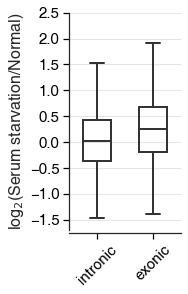

In [90]:
fig, ax = plt.subplots(1,1, figsize=(2,4), sharey=True)

my_pal = {"intronic": "#a84848", "exonic": "#22548a"}
ax = sns.boxplot(x='Exon_Intron', y = "log2FoldChange", data=DD_analysis, color='black', order=['intronic','exonic'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax, width=0.5, fliersize=3.5, linewidth=2, palette=my_pal)
#ax.artists[0].set_facecolor("#a84848")
#ax.artists[1].set_facecolor("#22546a")

ax.set_ylim(-1.7,2.5)
ax.set_ylabel("log$_2$(Serum starvation/Normal)", fontsize=16)
ax.set_xlabel("")
ax.set_title("", fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

for label in ax.get_yticklabels():
    label.set_fontsize(15)
for label in ax.get_xticklabels():
    label.set_fontsize(15)
    label.set_rotation(45)

#add_stat_annotation(ax, data=DD_analysis, x='Exon_Intron', y ='log2FoldChange', \
#                   box_pairs=[('intronic', 'exonic')], order=['intronic', 'exonic'], \
#                    test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', fontsize=15)

fig.show()
#plt.savefig("Results/Figures/211019-SS-Exon-Intron-box.svg", bbox_inches='tight')

In [91]:
a = DD_analysis[DD_analysis['Exon_Intron'] == 'exonic']["log2FoldChange"]
b = DD_analysis[DD_analysis['Exon_Intron'] == 'intronic']["log2FoldChange"]
mannwhitneyu(a, b, alternative = 'two-sided')[1]

0.00076699282589434

In [96]:
DD_analysis["Exon_Intron"].value_counts()

intronic    297
exonic      128
Name: Exon_Intron, dtype: int64

---
### P-rich dep/indep

P-rich domain dependency was obtained from the sRNA-seq results of HCT116

In [76]:
DD_HCT116 = pd.read_csv('../200521_HCT116_analysis/Results/200914_HCT116_DD_filtered.csv').set_index('mature')
DD_HCT116 = DD_HCT116[['baseMean', 'log2FoldChange', 'padj']]

- log2 FC cutoff = 1.53452924346508
- p-value cutoff = 0.05

In [77]:
log2FC_cutoff = 1.53452924346508

In [78]:
DD_HCT116.loc[DD_HCT116[(DD_HCT116["padj"] < 0.05) & (DD_HCT116["log2FoldChange"].abs() > log2FC_cutoff)].index, 'P-rich dep'] = "More dependent"
DD_HCT116.loc[DD_HCT116[(DD_HCT116["padj"] >= 0.05) | (DD_HCT116["log2FoldChange"].abs() <= log2FC_cutoff)].index, 'P-rich dep'] = "Less dependent"

In [79]:
DD_HCT116.head()

,baseMean,log2FoldChange,padj,P-rich dep
mature,,,,
hsa-let-7a-2-3p,52.394713,-0.901333,0.066836,Less dependent
hsa-let-7a-3p,410.786354,-0.089378,0.740194,Less dependent
hsa-let-7a-5p,15216.651736,0.009163,0.982280,Less dependent
hsa-let-7b-3p,113.500150,-0.583679,0.076425,Less dependent
hsa-let-7b-5p,3288.216511,-0.136267,0.691858,Less dependent


In [80]:
DD_analysis_wP = DD_analysis.join(DD_HCT116[['P-rich dep', 'log2FoldChange']], how='left',rsuffix='_116')
DD_analysis_wP.head()

,baseMean,log2FoldChange,pvalue,padj,pri-miRNA,Exon_Intron,P-rich dep,log2FoldChange_116
mature,,,,,,,,
hsa-let-7a-2-3p,470.730086,0.606168,1.638406e-04,1.201824e-03,hsa-let-7a-2,intronic,Less dependent,-0.901333
hsa-let-7b-3p,1045.693691,0.987534,2.427462e-04,1.710342e-03,hsa-let-7b,exonic,Less dependent,-0.583679
hsa-let-7b-5p,32680.718539,0.948030,3.481649e-09,8.032738e-08,hsa-let-7b,exonic,Less dependent,-0.136267
hsa-let-7c-5p,1437.848483,1.069767,1.533845e-07,2.283450e-06,hsa-let-7c,intronic,Less dependent,-0.235136
hsa-let-7d-3p,1326.729912,-0.229563,1.054674e-01,2.520916e-01,hsa-let-7d,intronic,More dependent,-2.068898


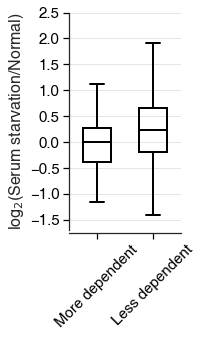

In [94]:
fig, ax = plt.subplots(1,1, figsize=(2,4), sharey=True)

ax = sns.boxplot(x='P-rich dep', y = "log2FoldChange", data=DD_analysis_wP, color='black', order=['More dependent','Less dependent'],\
                    boxprops={'facecolor': 'None'}, showfliers=False, ax=ax, width=0.5, fliersize=3.5, linewidth=2)

ax.set_ylim(-1.7,2.5)
ax.set_ylabel("log$_2$(Serum starvation/Normal)", fontsize=16)
ax.set_xlabel("")
ax.set_title("", fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.5)
ax.spines['bottom'].set_position(('outward',3))

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

for label in ax.get_yticklabels():
    label.set_fontsize(15)
for label in ax.get_xticklabels():
    label.set_fontsize(15)
    label.set_rotation(45)

#add_stat_annotation(ax, data=DD_analysis_wP, x='P-rich dep', y ='log2FoldChange', \
#                   box_pairs=[('More dependent', 'Less dependent')], order=['More dependent', 'Less dependent'], \
#                    test='Mann-Whitney', comparisons_correction=None, text_format='star', loc='inside', fontsize=15)

fig.show()
#plt.savefig("Results/Figures/211111-SS-P-dep-box.svg", bbox_inches='tight')

In [95]:
a = DD_analysis_wP[DD_analysis_wP['P-rich dep'] == 'Less dependent']['log2FoldChange']
b = DD_analysis_wP[DD_analysis_wP['P-rich dep'] == 'More dependent']['log2FoldChange']
mannwhitneyu(a, b, alternative='two-sided')[1]

0.0025830338020012226

In [59]:
DD_analysis_wP["P-rich dep"].value_counts()

Less dependent    170
More dependent    108
Name: P-rich dep, dtype: int64

---
### Draw the same volcano plot with color = P-rich dependency

In [62]:
w_spikeIn_info_DD = w_spikeIn_info[w_spikeIn_info['curated DROSHA dependency (HCT116)'] == 'DROSHA-dependent']
w_spikeIn_info_DD = w_spikeIn_info_DD.join(DD_HCT116[['log2FoldChange', 'P-rich dep']], rsuffix='_116', how='left')
w_spikeIn_info_DD.head()

,baseMean,log2FoldChange,lfcSE,pvalue,padj,curated DROSHA dependency (HCT116),log2FoldChange_116,P-rich dep
mature,,,,,,,,
hsa-let-7a-2-3p,470.730086,0.606168,0.169966,1.638406e-04,1.201824e-03,DROSHA-dependent,-0.901333,Less dependent
hsa-let-7a-3p,1745.327777,0.196499,0.137321,1.377258e-01,3.026688e-01,DROSHA-dependent,-0.089378,Less dependent
hsa-let-7a-5p,107685.554916,0.731498,0.133835,1.652180e-08,3.049924e-07,DROSHA-dependent,0.009163,Less dependent
hsa-let-7b-3p,1045.693691,0.987534,0.308271,2.427462e-04,1.710342e-03,DROSHA-dependent,-0.583679,Less dependent
hsa-let-7b-5p,32680.718539,0.948030,0.167534,3.481649e-09,8.032738e-08,DROSHA-dependent,-0.136267,Less dependent


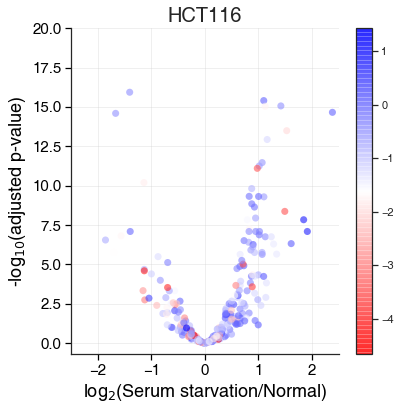

In [80]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.set_xlim(-2.5,2.5)
ax.set_ylim(-0.7,20)
#ax.plot([log2FC_cutoff, log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)
#ax.plot([-log2FC_cutoff, -log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)
#ax.plot(ax.get_xlim(),[-np.log10(0.05), -np.log10(0.05)],c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)

allmiRNA = ax.scatter(w_spikeIn_info_DD["log2FoldChange"], -np.log10(w_spikeIn_info_DD["padj"]), s=50, c= w_spikeIn_info_DD['log2FoldChange_116'], cmap='bwr_r',alpha=0.6, edgecolors='none', zorder=2)
#spkn = ax.scatter(w_spikeIn_info[w_spikeIn_info.index.str.contains('spk')]["log2FoldChange"], \
#                  -np.log10(w_spikeIn_info[w_spikeIn_info.index.str.contains('spk')]["padj"]),\
#                  c='#e7d6b1', alpha=0.6, s=50, edgecolors='none', zorder=2)
#DD = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["log2FoldChange"], \
#                -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["padj"]),\
#                c='#a84848', alpha=0.6, s=50, edgecolors='none', zorder=2)
#MCSnoT = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['Capped miRNA', "Mirtron", 'SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["log2FoldChange"], \
#                    -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['Capped miRNA', "Mirtron", 'SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["padj"]),\
#                    c='#3689a9', alpha=0.6, s=50, edgecolors='none', zorder=2)


ax.set_xlabel("log$_2$(Serum starvation/Normal)", fontsize=18, color='black')
ax.set_ylabel("-log$_{10}$(adjusted p-value)", fontsize=18, color='black')
#ax.legend((DD, MCSnoT, spkn), ("DROSHA-dependent", "Mirtron/Capped/tRNA/snoRNA-derived miRNA", "Spike-in"), \
#          frameon=True, bbox_to_anchor=(2.3,1), loc='upper right', scatterpoints=1, fontsize=15)


#for miRNA in w_spikeIn_sig.sort_values(by='padj').iloc[:25,:].index:
#    name = ('-').join(miRNA.split('-')[1:])
#    ax.text(w_spikeIn_sig.loc[miRNA, "log2FoldChange"], -np.log10(w_spikeIn_sig.loc[miRNA, "padj"]), name, fontsize=12, color='black')
#for miRNA in w_spikeIn_sig.sort_values(by='log2FoldChange', ascending=False).iloc[:3,:].index:
#    name = ('-').join(miRNA.split('-')[1:])
#    ax.text(w_spikeIn_sig.loc[miRNA, "log2FoldChange"], -np.log10(w_spikeIn_sig.loc[miRNA, "padj"]), name, fontsize=12, color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, zorder=0)
ax.grid(axis='x', alpha=0.3, zorder=0)
#ax.spines['bottom'].set_position(('outward', 4))

ax.set_title("HCT116",fontsize=20)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

fig.colorbar(allmiRNA, ax=ax)

fig.show()
#plt.savefig("Results/Figures/211111-data-volcano-SS.pdf", bbox_inches='tight')

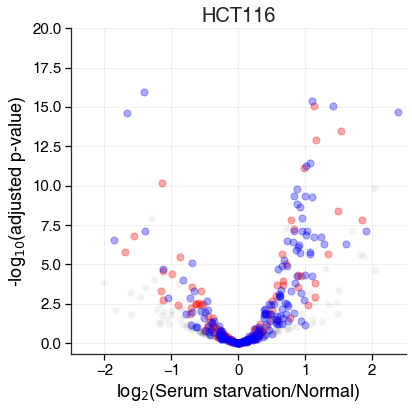

In [81]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.set_xlim(-2.5,2.5)
ax.set_ylim(-0.7,20)
#ax.plot([log2FC_cutoff, log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)
#ax.plot([-log2FC_cutoff, -log2FC_cutoff], ax.get_ylim(),c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)
#ax.plot(ax.get_xlim(),[-np.log10(0.05), -np.log10(0.05)],c='black', alpha=0.7, ls='--', linewidth=1.2, zorder=1)

allmiRNA = ax.scatter(w_spikeIn_info_DD["log2FoldChange"], -np.log10(w_spikeIn_info_DD["padj"]), s=50, c= 'grey',alpha=0.1, edgecolors='none')
dep = ax.scatter(w_spikeIn_info_DD[w_spikeIn_info_DD['P-rich dep'] == 'More dependent']['log2FoldChange'], -np.log10(w_spikeIn_info_DD[w_spikeIn_info_DD['P-rich dep'] == 'More dependent']['padj']), s=50, c = 'red', alpha=0.3)
indep = ax.scatter(w_spikeIn_info_DD[w_spikeIn_info_DD['P-rich dep'] == 'Less dependent']['log2FoldChange'], -np.log10(w_spikeIn_info_DD[w_spikeIn_info_DD['P-rich dep'] == 'Less dependent']['padj']), s=50, c = 'blue', alpha=0.3)

#spkn = ax.scatter(w_spikeIn_info[w_spikeIn_info.index.str.contains('spk')]["log2FoldChange"], \
#                  -np.log10(w_spikeIn_info[w_spikeIn_info.index.str.contains('spk')]["padj"]),\
#                  c='#e7d6b1', alpha=0.6, s=50, edgecolors='none', zorder=2)
#DD = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["log2FoldChange"], \
#                -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"]=="DROSHA-dependent"]["padj"]),\
#                c='#a84848', alpha=0.6, s=50, edgecolors='none', zorder=2)
#MCSnoT = ax.scatter(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['Capped miRNA', "Mirtron", 'SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["log2FoldChange"], \
#                    -np.log10(w_spikeIn_sig[w_spikeIn_sig["curated DROSHA dependency (HCT116)"].isin(['Capped miRNA', "Mirtron", 'SnoRNA-derived miRNA', 'tRNA-related miRNA'])]["padj"]),\
#                    c='#3689a9', alpha=0.6, s=50, edgecolors='none', zorder=2)


ax.set_xlabel("log$_2$(Serum starvation/Normal)", fontsize=18, color='black')
ax.set_ylabel("-log$_{10}$(adjusted p-value)", fontsize=18, color='black')
#ax.legend((DD, MCSnoT, spkn), ("DROSHA-dependent", "Mirtron/Capped/tRNA/snoRNA-derived miRNA", "Spike-in"), \
#          frameon=True, bbox_to_anchor=(2.3,1), loc='upper right', scatterpoints=1, fontsize=15)


#for miRNA in w_spikeIn_sig.sort_values(by='padj').iloc[:25,:].index:
#    name = ('-').join(miRNA.split('-')[1:])
#    ax.text(w_spikeIn_sig.loc[miRNA, "log2FoldChange"], -np.log10(w_spikeIn_sig.loc[miRNA, "padj"]), name, fontsize=12, color='black')
#for miRNA in w_spikeIn_sig.sort_values(by='log2FoldChange', ascending=False).iloc[:3,:].index:
#    name = ('-').join(miRNA.split('-')[1:])
#    ax.text(w_spikeIn_sig.loc[miRNA, "log2FoldChange"], -np.log10(w_spikeIn_sig.loc[miRNA, "padj"]), name, fontsize=12, color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, zorder=0)
ax.grid(axis='x', alpha=0.3, zorder=0)
#ax.spines['bottom'].set_position(('outward', 4))

ax.set_title("HCT116",fontsize=20)

for label in (ax.get_xticklabels() + ax.get_yticklabels()) :
    label.set_fontsize(15)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

fig.show()
#plt.savefig("Results/Figures/211111-data-volcano-SS.pdf", bbox_inches='tight')

In [84]:
w_spikeIn_info_DD.sort_values(by='log2FoldChange', ascending=False).head(10)

,baseMean,log2FoldChange,lfcSE,pvalue,padj,curated DROSHA dependency (HCT116),log2FoldChange_116,P-rich dep
mature,,,,,,,,
hsa-miR-205-5p,196.756989,3.825208,0.296375,3.847010e-39,1.775395e-36,DROSHA-dependent,NaN,NaN
hsa-miR-486-3p,27.877666,3.381873,0.724604,2.472874e-07,3.356562e-06,DROSHA-dependent,NaN,NaN
hsa-miR-486-5p,160.228055,3.309426,0.310348,1.193141e-27,2.753173e-25,DROSHA-dependent,NaN,NaN
hsa-miR-338-3p,18.738918,3.141919,0.738448,2.209988e-06,2.487585e-05,DROSHA-dependent,NaN,NaN
hsa-miR-34c-5p,27.165961,3.107400,0.610395,3.627549e-08,6.087686e-07,DROSHA-dependent,NaN,NaN
hsa-miR-95-3p,316.127848,2.731614,0.199800,1.223699e-43,1.129474e-40,DROSHA-dependent,-0.734241,Less dependent
hsa-miR-328-3p,166.979695,2.381135,0.291499,2.388334e-17,2.204432e-15,DROSHA-dependent,0.250276,Less dependent
hsa-miR-194-5p,555.696056,2.060324,0.196850,1.120565e-26,2.068564e-24,DROSHA-dependent,-0.559260,Less dependent
hsa-miR-3065-3p,30.986278,2.053329,0.488479,2.274106e-06,2.511224e-05,DROSHA-dependent,NaN,NaN
